In [28]:
import numpy as np
import pandas as pd
import timeit

%matplotlib inline
import matplotlib.pyplot as plt

 - **Layers**: an Integer value representing the total number of hidden layers in the network (input and output layers are extra).
 
 - **Nodes**: an integer array of size [0,..,Layers+1] containing the dimensions of the neural
network. Nodes[0] shall represent the input size (typically, 50), Nodes[Layers+1]
shall represent the number of output nodes (typically, 1). All other values Nodes[i]
represent the number of nodes in hidden layer i.

 - **NNodes**: a possible alternative to the Nodes parameter for situations where you want
each hidden layer of the neural network to be of the same size. In this case, the size of
the output layer is assumed to be 1, and the size of the input layer can be inferred from
the dataset.

 - **Activations**: an array of size [0,..,Layers+1] (for the sake of compatibility) in which
Activations[0] and Activations[Layers+1] are not used, while all other
Activations[i] values are labels indicating the activation function used in layer i.
This allows you to build neural networks with different activation functions in each layer.

 - **ActivationFn**: a possible alternative to Activations when all hidden layers of your neural
network use the same activation function.

In [68]:
class NeuralNetwork:
    #Layers: an Integer value representing the total number of hidden layers in the network 
    #        (input and output layers are extra)

    def __init__(self, Layers, Nodes, NNodes, Activations, ActivationFn, a=None):
        self.Layers = Layers
        self.Nodes = Nodes
        self.NNodes = NNodes
        self.Activations = Activations
        self.ActivationFn = ActivationFn
        self.a = a # The coefficient used if using leaky Relu as the activation function, default is None
        self.weights = None
        
       
        
    # Forward Pass
        
    def Relu(self,e):
        return max(0,e)
    
    def leakyRelu(self,e):
        if e > 0:
            return e
        else:
            return self.a*e
        
    def sigmoid(self,e):
        return 1/(1+np.exp(1)**-e)
    
    def tanh(self,e):
        return 2*self.sigmoid(2*e) - 1
    
    def applyActivation(self,layer,i):
        acttype = self.Activations[i]
        if acttype == "Relu":
            return layer.applymap(self.Relu)
        elif acttype == "leaky":
            return layer.applymap(self.leakyRelu)
        elif acttype == "sigmoid":
            return layer.applymap(self.sigmoid)
        elif acttype == "tanh":
            return layer.applymap(self.tanh)
    
    def loss(self,z,y):
        # Performs L2 loss (for this project)
        L = 0.5*((np.array(z)-np.array(y))**2) # Assumes the squaring is element wise
        L = np.sum(L) * (1/len(z)) # Take average of all the losses
        return L     
        


    def forward_pass(self, X, y, weights):
            # Assume X already has a column of ones for bias term.
            # Assume weights include the weights for the bias term when going into next layer

            savings = [X]

            # From input layer to first hidden layer
            h = X.dot(weights[0]) # Get first hidden layer without the bias node added in
            h['ones'] = 1 # Add in bias node to the hidden layer
            savings.append(h) # Saving intermediate values
            hact = self.applyActivation(h,0) # Perform activation
            hact['ones'] = 1
            savings.append(hact) # Saving intermediate values
            h = hact

            for i in range(1,len(weights)):
                if i != len(weights)-1: # A hidden layer
                    h = h.dot(weights[i])
                    h['ones'] = 1 # Add in bias node to the hidden layer
                    savings.append(h) # Saving intermediate values
                    hact = self.applyActivation(h,i) # Perform activation
                    hact['ones'] = 1
                    savings.append(hact) # Saving intermediate values
                    h = hact
                else: # For Z value/vector
                    z = h.dot(weights[i])
                    savings.append(z)

                    # Calculate loss
                    L = self.loss(z,y)
                    savings.append(L) # Are we saving average loss over the batch?
            return savings
    
    # Backwards pass
    def J_loss(self,z,y):
        B = len(y)
        #print(z.subtract(y,axis=0))
        #J = (1/B)*(np.array(z) - np.array(y))
        J = (1/B)*(z.subtract(y,axis=0))
        return J
    
    def J_sigma(self, X, activation):
        if activation == "sigmoid":
            S = (1/(1+np.exp(-X)))
            return S.multiply(1-S)
        elif activation == "tanh":
            return 1-(X**2)
        elif activation == "Relu":
            return (X > 0).astype(int)
        elif activation == "leaky":
            return (X>0).astype(int) +  self.a*(X<0).astype(int)
        
    def J_inputlayer(self,J,w):
        #return J.dot(w.T)
        #print(w)
        #w = pd.DataFrame(w).drop([len(w)-1],axis=0)
        w = pd.DataFrame(w).iloc[:-1]
        return J.dot(w.T)
    
    def J_weight(self,J,X):
        return np.array(X.T).dot(J)
    
    def back_propagation(self,X,y,intermediates,weights,lr,batch):
        J = pd.DataFrame(self.J_loss(intermediates[-2],y)) # Compute the jacobian of the loss layer evaluated at z
        w_on = True
        w_count = len(weights)-1
        act_count = len(self.Activations) - 1
        for i in range(-3,-len(intermediates),-1):
            if w_on:
                J_wn = self.J_weight(J,intermediates[i])  # Calculate the jacobian of the weights evaluated at sigma
                J = self.J_inputlayer(J,weights[w_count])  # Update jacobian by computing the jacobian of dense layer wrt input
                weights[w_count] = weights[w_count] - lr*J_wn*(1/batch) # Update the weights
                w_count = w_count - 1 # Update the index for the next set of weights
                w_on = False # Next derivative evaluated at intermediates[i] will not update the weights
            else:
                J = np.multiply(J,self.J_sigma(intermediates[i].drop("ones",axis=1), self.Activations[act_count])) # For activation, we use element-wise multiplication
                w_on = True
                act_count = act_count-1
        # Update last set of weights (W_1)
        J_w1 = self.J_weight(J,intermediates[-len(intermediates)])
        weights[w_count] = weights[w_count] - lr*J_w1*(1/batch)
        return weights

    
    # Training
    
    def setup(self,width):
        if self.NNodes != None:
            self.Nodes = [width] + ([self.NNodes]*self.Layers) + [1]
        if self.ActivationFn != None:
            self.Activations = [self.ActivationFn]*(self.Layers+1) 
            


    def initialize_weights(self):
        weights = []
        for i in range(len(self.Nodes)-1):
            M = self.Nodes[i] 
            N = self.Nodes[i+1] 
            if self.Activations[i] in ["Relu","leaky"]:
                w = np.random.normal(loc=0,scale = np.sqrt(2/(M)),size=(M,N))
                w = np.append(w,[[0]*N], axis=0) # BIAS
                weights.append(w)
            else:
                w = np.random.normal(loc=0,scale = np.sqrt(2/(M+N)),size=(M,N)) 
                w = np.append(w,[[0]*N], axis=0) #BIAS
                weights.append(w)
        return weights
    
    def train(self,X,y,lr,batch,max_epoch,eps):
        Xsamp = X.sample(batch)
        ysamp = y.loc[Xsamp.index]
        Losses = []
        
        # Set up
        self.setup(Xsamp.shape[1])
        
        # first iteration
        epoch = 1
        weights = self.initialize_weights()
        Xsamp["ones"] = 1
        intermediates = self.forward_pass(Xsamp,ysamp,weights)
        weights = self.back_propagation(Xsamp,ysamp,intermediates,weights,lr,batch)
        L0 = intermediates[-1]
        Losses.append(L0)
        print("epoch:",epoch,"    Loss:",L0)
        while(L0 > eps):
            Xsamp = X.sample(batch)
            ysamp = y.loc[Xsamp.index]
            Xsamp["ones"] = 1
            intermediates = self.forward_pass(Xsamp,ysamp,weights)
            weights = self.back_propagation(Xsamp,ysamp,intermediates,weights,lr,batch)
            L0 = intermediates[-1]
            Losses.append(L0)
            epoch = epoch + 1
            print("epoch:",epoch,"    Loss:",L0)
            if epoch == max_epoch:
                break
        self.weights = weights
        print("epoch:",epoch)
        #return L0
        return Losses
    
    def predict(self,X_test,y_test):
        X_test["ones"] = 1
        intermediates = self.forward_pass(X_test,y_test,self.weights)
        predictions = intermediates[-2]
        return predictions

In [19]:
df = pd.read_csv('datasets/sberbank-russian-housing-market/train.csv')
df = df.select_dtypes(exclude=['category', 'object'])
df = df.drop(['id'], axis=1)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,-0.294873,-0.141596,-0.690013,NaN,NaN,NaN,NaN,NaN,NaN,-0.544788,...,-0.313871,-0.238993,-0.326975,-0.070250,-0.174277,0.915176,-0.420245,-0.017208,-0.406425,-0.266324
1,-0.531523,-0.294604,-0.877987,NaN,NaN,NaN,NaN,NaN,NaN,-0.390702,...,-0.232198,-0.274222,-0.326975,-0.001564,-0.026433,0.915176,0.065654,0.285221,1.638925,-0.234943
2,-0.294873,-0.103343,-1.065960,NaN,NaN,NaN,NaN,NaN,NaN,-0.622239,...,-0.300259,-0.274222,-0.326975,-0.138936,-0.068674,-0.726162,-0.225885,0.306823,0.820785,-0.297704
3,0.914671,0.298304,0.249854,NaN,NaN,NaN,NaN,NaN,NaN,-0.245700,...,-0.286647,-0.309452,-0.142429,-0.379335,-0.554448,-0.726162,-0.420245,-0.578861,-0.610960,1.250402
4,0.599138,0.814708,-0.690013,NaN,NaN,NaN,NaN,NaN,NaN,-0.448374,...,3.905860,3.424887,2.810299,4.119571,4.345529,2.556515,4.001437,3.071885,1.638925,1.926434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,-0.268578,-0.141596,-0.126093,-0.526757,-0.558443,-0.007080,0.105890,-0.014127,1.014604,-0.368245,...,-0.232198,-0.203763,-0.326975,-0.001564,-0.089795,0.915176,-0.323065,0.674058,0.002645,0.057942
30467,0.835788,0.470439,-0.877987,-0.526757,0.116722,-0.007339,2.453903,0.127389,1.014604,-0.501211,...,3.824188,4.129479,4.102117,2.848887,3.205018,0.915176,3.564128,2.553436,1.843460,3.739925
30468,-0.242284,NaN,0.437827,1.101332,-0.558443,NaN,-1.068116,-0.191022,-1.257808,0.381575,...,-0.422767,-0.344682,-0.326975,-0.448021,-0.385483,-0.726162,-0.371655,-0.902892,-1.020030,-0.031815
30469,0.257310,-0.045965,-0.502040,0.361292,-0.558443,-0.006899,0.105890,0.162768,-0.121602,-0.562102,...,-0.136914,-0.344682,-0.142429,-0.310650,0.015808,0.915176,-0.225885,0.263619,0.207180,1.334084


In [21]:
df_corr = df.corr()
df_corr

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
full_sq,1.000000,0.161112,0.089649,0.119225,0.032866,-0.006041,0.695444,0.020026,-0.091348,0.056303,...,0.039083,0.040059,0.043560,0.026895,0.028579,0.021568,0.030218,0.001580,-0.041254,0.341840
life_sq,0.161112,1.000000,0.045090,0.042442,0.011393,-0.002401,0.191024,0.000633,-0.066633,0.061395,...,0.028735,0.031551,0.034888,0.017845,0.018114,0.009945,0.022737,-0.014499,-0.050337,0.165606
floor,0.089649,0.045090,1.000000,0.454488,-0.009043,0.001192,-0.005657,-0.008457,-0.113906,-0.019448,...,-0.034791,-0.029636,-0.022303,-0.044398,-0.045614,-0.012256,-0.044236,-0.102101,-0.123843,0.117447
max_floor,0.119225,0.042442,0.454488,1.000000,0.045915,-0.000261,-0.014220,0.020345,-0.072161,-0.092954,...,-0.040235,-0.033662,-0.029525,-0.048235,-0.048240,-0.058255,-0.048664,-0.099855,-0.113341,0.094386
material,0.032866,0.011393,-0.009043,0.045915,1.000000,-0.004402,-0.026924,0.038747,-0.034225,0.001182,...,0.050919,0.043660,0.044403,0.038480,0.044701,0.050355,0.044502,0.098482,0.076378,0.064047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mosque_count_5000,0.021568,0.009945,-0.012256,-0.058255,0.050355,0.019631,0.062785,0.013183,0.091894,-0.086786,...,0.529434,0.492859,0.481481,0.502028,0.550342,1.000000,0.499376,0.518500,0.242078,0.175107
leisure_count_5000,0.030218,0.022737,-0.044236,-0.048664,0.044502,-0.000830,0.058663,-0.006259,-0.003876,-0.195067,...,0.986206,0.975462,0.948391,0.969029,0.975259,0.499376,1.000000,0.809169,0.463053,0.200448
sport_count_5000,0.001580,-0.014499,-0.102101,-0.099855,0.098482,0.005978,0.089908,0.016866,0.194379,-0.416222,...,0.824139,0.778770,0.753384,0.825883,0.847771,0.518500,0.809169,1.000000,0.733897,0.294864
market_count_5000,-0.041254,-0.050337,-0.123843,-0.113341,0.076378,0.007362,0.061674,0.026404,0.273385,-0.449849,...,0.432265,0.380154,0.353270,0.482547,0.514344,0.242078,0.463053,0.733897,1.000000,0.194021


In [22]:
remove_cols = set()
for col1 in df.columns:
    if col1 in remove_cols or col1 == 'price_doc':
        continue
        
    for col2 in df.columns:
        if col1 == col2 or col2 in remove_cols or col2 == 'price_doc':
            continue
            
        if abs(df_corr[col1][col2]) > 0.75:
            remove_cols.add(col2)

In [23]:
len(remove_cols)

181

In [24]:
df = df.drop(list(remove_cols), axis=1)

In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

In [26]:
df

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,market_count_2000,prom_part_3000,cafe_sum_3000_min_price_avg,mosque_count_3000,green_part_5000,trc_sqm_5000,cafe_sum_5000_min_price_avg,mosque_count_5000,market_count_5000,price_doc
0,-0.294873,-0.141596,-0.690013,-0.378749,-0.558443,-0.007087,0.692894,0.021252,1.014604,-0.544788,...,-0.118758,0.324073,-0.563478,-0.444553,-0.863607,2.849088,-0.370906,0.915176,-0.406425,-0.266324
1,-0.531523,-0.294604,-0.877987,-0.008729,2.142218,-0.007090,-1.068116,0.074321,0.446501,-0.390702,...,-0.815729,2.058742,-0.602093,-0.444553,-1.116099,0.856963,-0.598980,0.915176,1.638925,-0.234943
2,-0.294873,-0.103343,-1.065960,-0.822773,0.116722,-0.007142,1.279897,-0.067196,-0.121602,-0.622239,...,2.669128,1.950404,-0.305624,-0.444553,-0.810075,0.397215,-0.409553,-0.726162,0.820785,-0.297704
3,0.914671,0.298304,0.249854,0.657308,-0.558443,-0.006931,1.279897,0.162768,1.014604,-0.245700,...,0.578213,-0.933153,-0.210491,-0.444553,-0.766358,-0.230586,1.092352,-0.726162,-0.610960,1.250402
4,0.599138,0.814708,-0.690013,-0.822773,1.129470,-0.007242,1.279897,-0.067196,0.446501,-0.448374,...,1.275185,-0.296981,0.388965,1.788546,-1.283832,2.318075,0.582531,2.556515,1.638925,1.926434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,-0.268578,-0.141596,-0.126093,-0.526757,-0.558443,-0.007080,0.105890,-0.014127,1.014604,-0.368245,...,1.275185,1.294077,-0.526826,1.788546,-0.646803,1.367864,-0.493079,0.915176,0.002645,0.057942
30467,0.835788,0.470439,-0.877987,-0.526757,0.116722,-0.007339,2.453903,0.127389,1.014604,-0.501211,...,0.578213,0.046929,0.580079,1.788546,-1.291862,3.156912,0.802667,0.915176,1.843460,3.739925
30468,-0.242284,0.135733,0.437827,1.101332,-0.558443,-0.019870,-1.068116,-0.191022,-1.257808,0.381575,...,-0.815729,-1.117076,-0.294195,-0.444553,1.146513,-0.967931,-0.116324,-0.726162,-1.020030,-0.031815
30469,0.257310,-0.045965,-0.502040,0.361292,-0.558443,-0.006899,0.105890,0.162768,-0.121602,-0.562102,...,0.578213,-1.197699,-0.376873,1.788546,0.677217,0.289263,-0.406141,0.915176,0.207180,1.334084


In [73]:
X = df.drop('price_doc', axis=1)
y = df['price_doc']

X_train = X.iloc[:int(16610/2)]
y_train = y.iloc[:int(16610/2)]
X_test = X.iloc[int(16610/2)+1:]
y_test = y.iloc[int(16610/2)+1:]

NN = NeuralNetwork(Layers=4, Nodes=[93,30,30,20,10,1], NNodes=None, Activations=None, ActivationFn="Relu", a=None)
start_time = timeit.default_timer()
res = NN.train(X_train,y_train,0.0000001,1000,10,10**-3)
elapsed = timeit.default_timer() - start_time
print("Time (minutes) elapsed for this cell:", elapsed/60)
print("Loss:", res[-1])

epoch: 1     Loss: 3756.1425329335602
epoch: 2     Loss: 1718.8651946040166
epoch: 3     Loss: 2337.8301841698863
epoch: 4     Loss: 2240.9072516765773
epoch: 5     Loss: 2011.6986048744698
epoch: 6     Loss: 1706.2802943843972
epoch: 7     Loss: 1996.480755301558
epoch: 8     Loss: 1826.8352800603982
epoch: 9     Loss: 2076.5462154991083
epoch: 10     Loss: 1906.1989172531767
epoch: 10
Time (minutes) elapsed for this cell: 0.01637244166666581
Loss: 1906.1989172531767


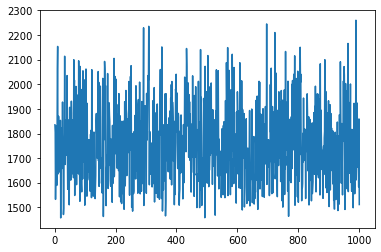

In [43]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(res), 10)
ax.plot(x, res);

In [74]:
np.sqrt(np.sum(np.abs(np.array(y)-np.array(NN.predict(X_test,y_test))))/len(df))

<ipython-input-68-470c5b46f6fd>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["ones"] = 1


200.61854538559714